In [10]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector, random_clifford, Pauli, Operator, partial_trace, entropy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from quantum_simulation_recipe.spin import Nearest_Neighbour_1d
from quantum_simulation_recipe.trotter import *
from quantum_simulation_recipe.bounds import norm, tight_bound, commutator
from quantum_simulation_recipe.plot_config import *
from time import sleep
from tqdm import tqdm

def StateError(state,ErrorU):
    st=ErrorU @ state
    error=np.real(st.conj().T @ st)
    return np.sqrt(error)

States_of_different_magics=np.load("./data/differentstates.npy")
Magics=np.load("./data/differentmagics_right.npy")

In [11]:
# Model: 1D Heisenberg model
n=10
J,h=1,0.2
t=10
r=100
delta_t=t/r
order=1
hnn=Nearest_Neighbour_1d(n=n,Jx=J,Jy=J,Jz=J,hx=h,hy=0,hz=0,pbc=True)
h_list=hnn.ham_xyz
approx_U=pf(h_list,t=delta_t,r=1,order=1)
exact_U=expH(hnn.ham,delta_t)
Error_U=exact_U-approx_U

#Distribution of errors for different magics
SampleScale=10000
Errors=np.load("./OtherHamiltonians/5qubitsHeisenbergGCdistribution.npy").tolist()
print(len(Errors[0]))
generate_or_not=True
if(generate_or_not):
    Update_errors=[]
    j=0
    for i,st in enumerate(States_of_different_magics):
        if i in [0,1,2,4,8]: 
            pbar=tqdm(total=SampleScale)
            step=0
            state=Statevector(st)
            sample=Errors[j]
            while step < SampleScale:
                state=state.evolve(random_clifford(n))
                error=StateError(state.data,Error_U)
                sample.append(error)
                pbar.update(1)
                step+=1  
            pbar.close()
            Update_errors.append(sample)
            j+=1
    #print(Update_errors)
    np.save("./OtherHamiltonians/5qubitsHeisenbergGCdistribution.npy",Update_errors)

71105


100%|██████████| 10000/10000 [5:53:35<00:00,  2.12s/it]    


R-squared for kurtosis fit: 0.9852428079167997


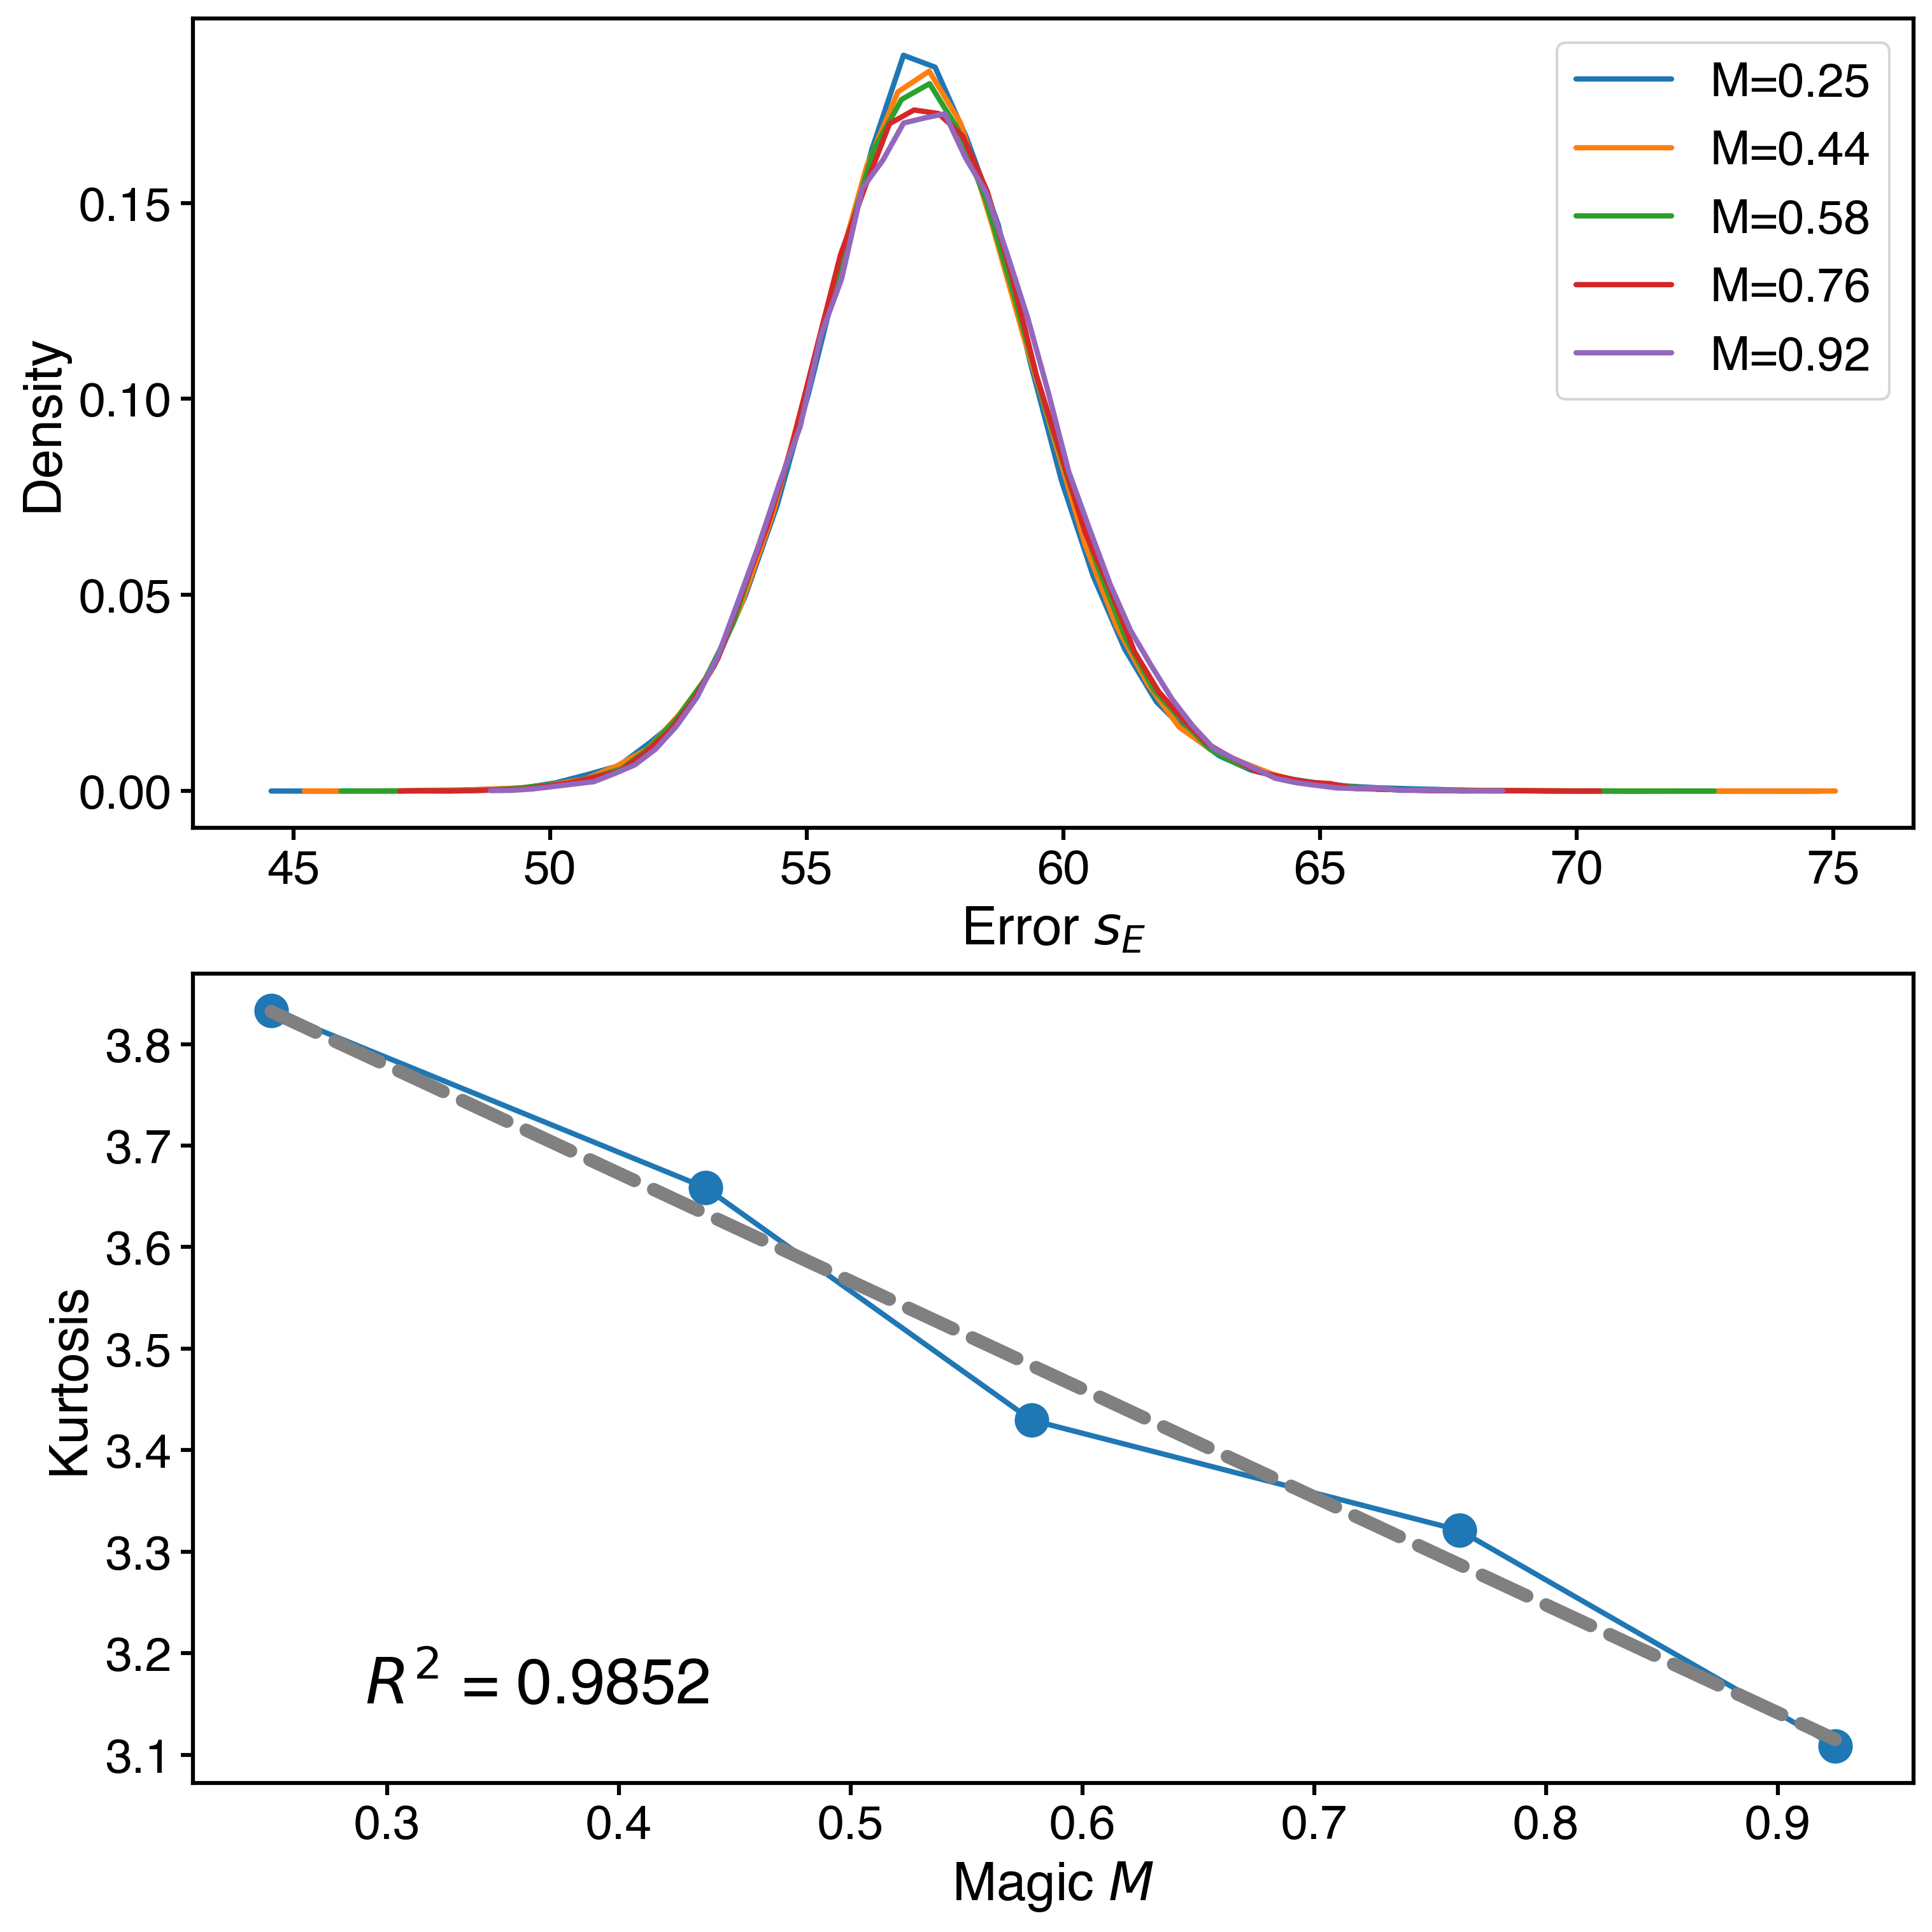

In [12]:
fig, (ax_up, ax_down) = plt.subplots(2,1, figsize=(10,10), layout='constrained')
label_size=20
ax_up.set_xlabel(r"Error $s_E$", fontsize=label_size)
ax_up.set_ylabel(r"Density", fontsize=label_size)
ax_down.set_xlabel(r"Magic $M$", fontsize=label_size)
ax_down.set_ylabel(r"Kurtosis", fontsize=label_size)
ax_up.tick_params(axis='both', which='major', labelsize=label_size-2)
ax_down.tick_params(axis='both', which='major', labelsize=label_size-2)
kurtosis=[]
magics_to_plot=[]
j=0
for i in range(len(Magics)):
    if i in [0,1,2,4,8]:
        S_E=np.power(Update_errors[j],2)/np.power(delta_t,2*order+2)
        hists, bins = np.histogram(S_E, 50, density=True)
        ax_up.plot(bins[:-1], np.power(hists, 1),label=f'M={Magics[i]:.2f}')
        kurtosis.append(np.mean((S_E-np.mean(S_E))**4)/np.var(S_E)**2)
        magics_to_plot.append(Magics[i])
        j+=1
ax_down.plot(magics_to_plot, kurtosis, marker='o')
#Linear fit
z1 = np.polyfit(magics_to_plot, kurtosis, 1)
p1 = np.poly1d(z1)
R_squared = np.corrcoef(kurtosis, p1(magics_to_plot))[0,1]**2
print(f"R-squared for kurtosis fit: {R_squared}")
moments_pre = p1(magics_to_plot)
ax_down.plot(magics_to_plot, moments_pre, "--", color='gray', linewidth=5, label='Linear fit')
plt.text(0.2, 0.12, rf"$R^2$ = {R_squared:.4f}", ha='center', va='center', transform=ax_down.transAxes, fontsize=24)
ax_up.legend()
plt.show()

In [13]:
#Distribution of errors for different entanglement
def random_local(state):
    n=state.num_qubits
    for i in range(n):
        state=state.evolve(random_clifford(1),[i])
    return state
States_of_typical_entanglement=np.load("./vardata/entstates.npy")
States_of_atypical_entanglement=np.load("./vardata/antientstates.npy")
Tyentropies=np.load("vardata/part4typical.npy")
Atyentropies=np.load("vardata/part4atypical.npy")

if(True):
    SampleScale=100
    TypicalErrors=np.load("./OtherHamiltonians/HeisenbergLUtypical.npy").tolist()
    AtypicalErrors=np.load("./OtherHamiltonians/HeisenbergLUatypical.npy").tolist()
    Typical_errors_update=[]
    Atypical_errors_update=[]
    pbar=tqdm(total=len(States_of_typical_entanglement))
    for i,st in enumerate(States_of_typical_entanglement):
        step=0
        state=Statevector(st)
        sample=TypicalErrors[i]
        while step < SampleScale:
            state=random_local(state)
            error=StateError(state.data,Error_U)
            sample.append(error)
            step+=1  
        Typical_errors_update.append(sample)
        pbar.update(1)
    pbar.close()
    #print(Typical_errors_update)
    np.save("./OtherHamiltonians/HeisenbergLUtypical.npy",Typical_errors_update)

    pbar=tqdm(total=len(States_of_atypical_entanglement))
    for i,st in enumerate(States_of_atypical_entanglement):
        step=0
        state=Statevector(st)
        sample=AtypicalErrors[i]
        while step < SampleScale:
            state=random_local(state)
            error=StateError(state.data,Error_U)
            sample.append(error)
            step+=1  
        Atypical_errors_update.append(sample)
        pbar.update(1)
    pbar.close()
    #print(Atypical_errors_update)
    np.save("./OtherHamiltonians/HeisenbergLUatypical.npy",Atypical_errors_update)
    

100%|██████████| 41/41 [00:15<00:00,  2.69it/s]


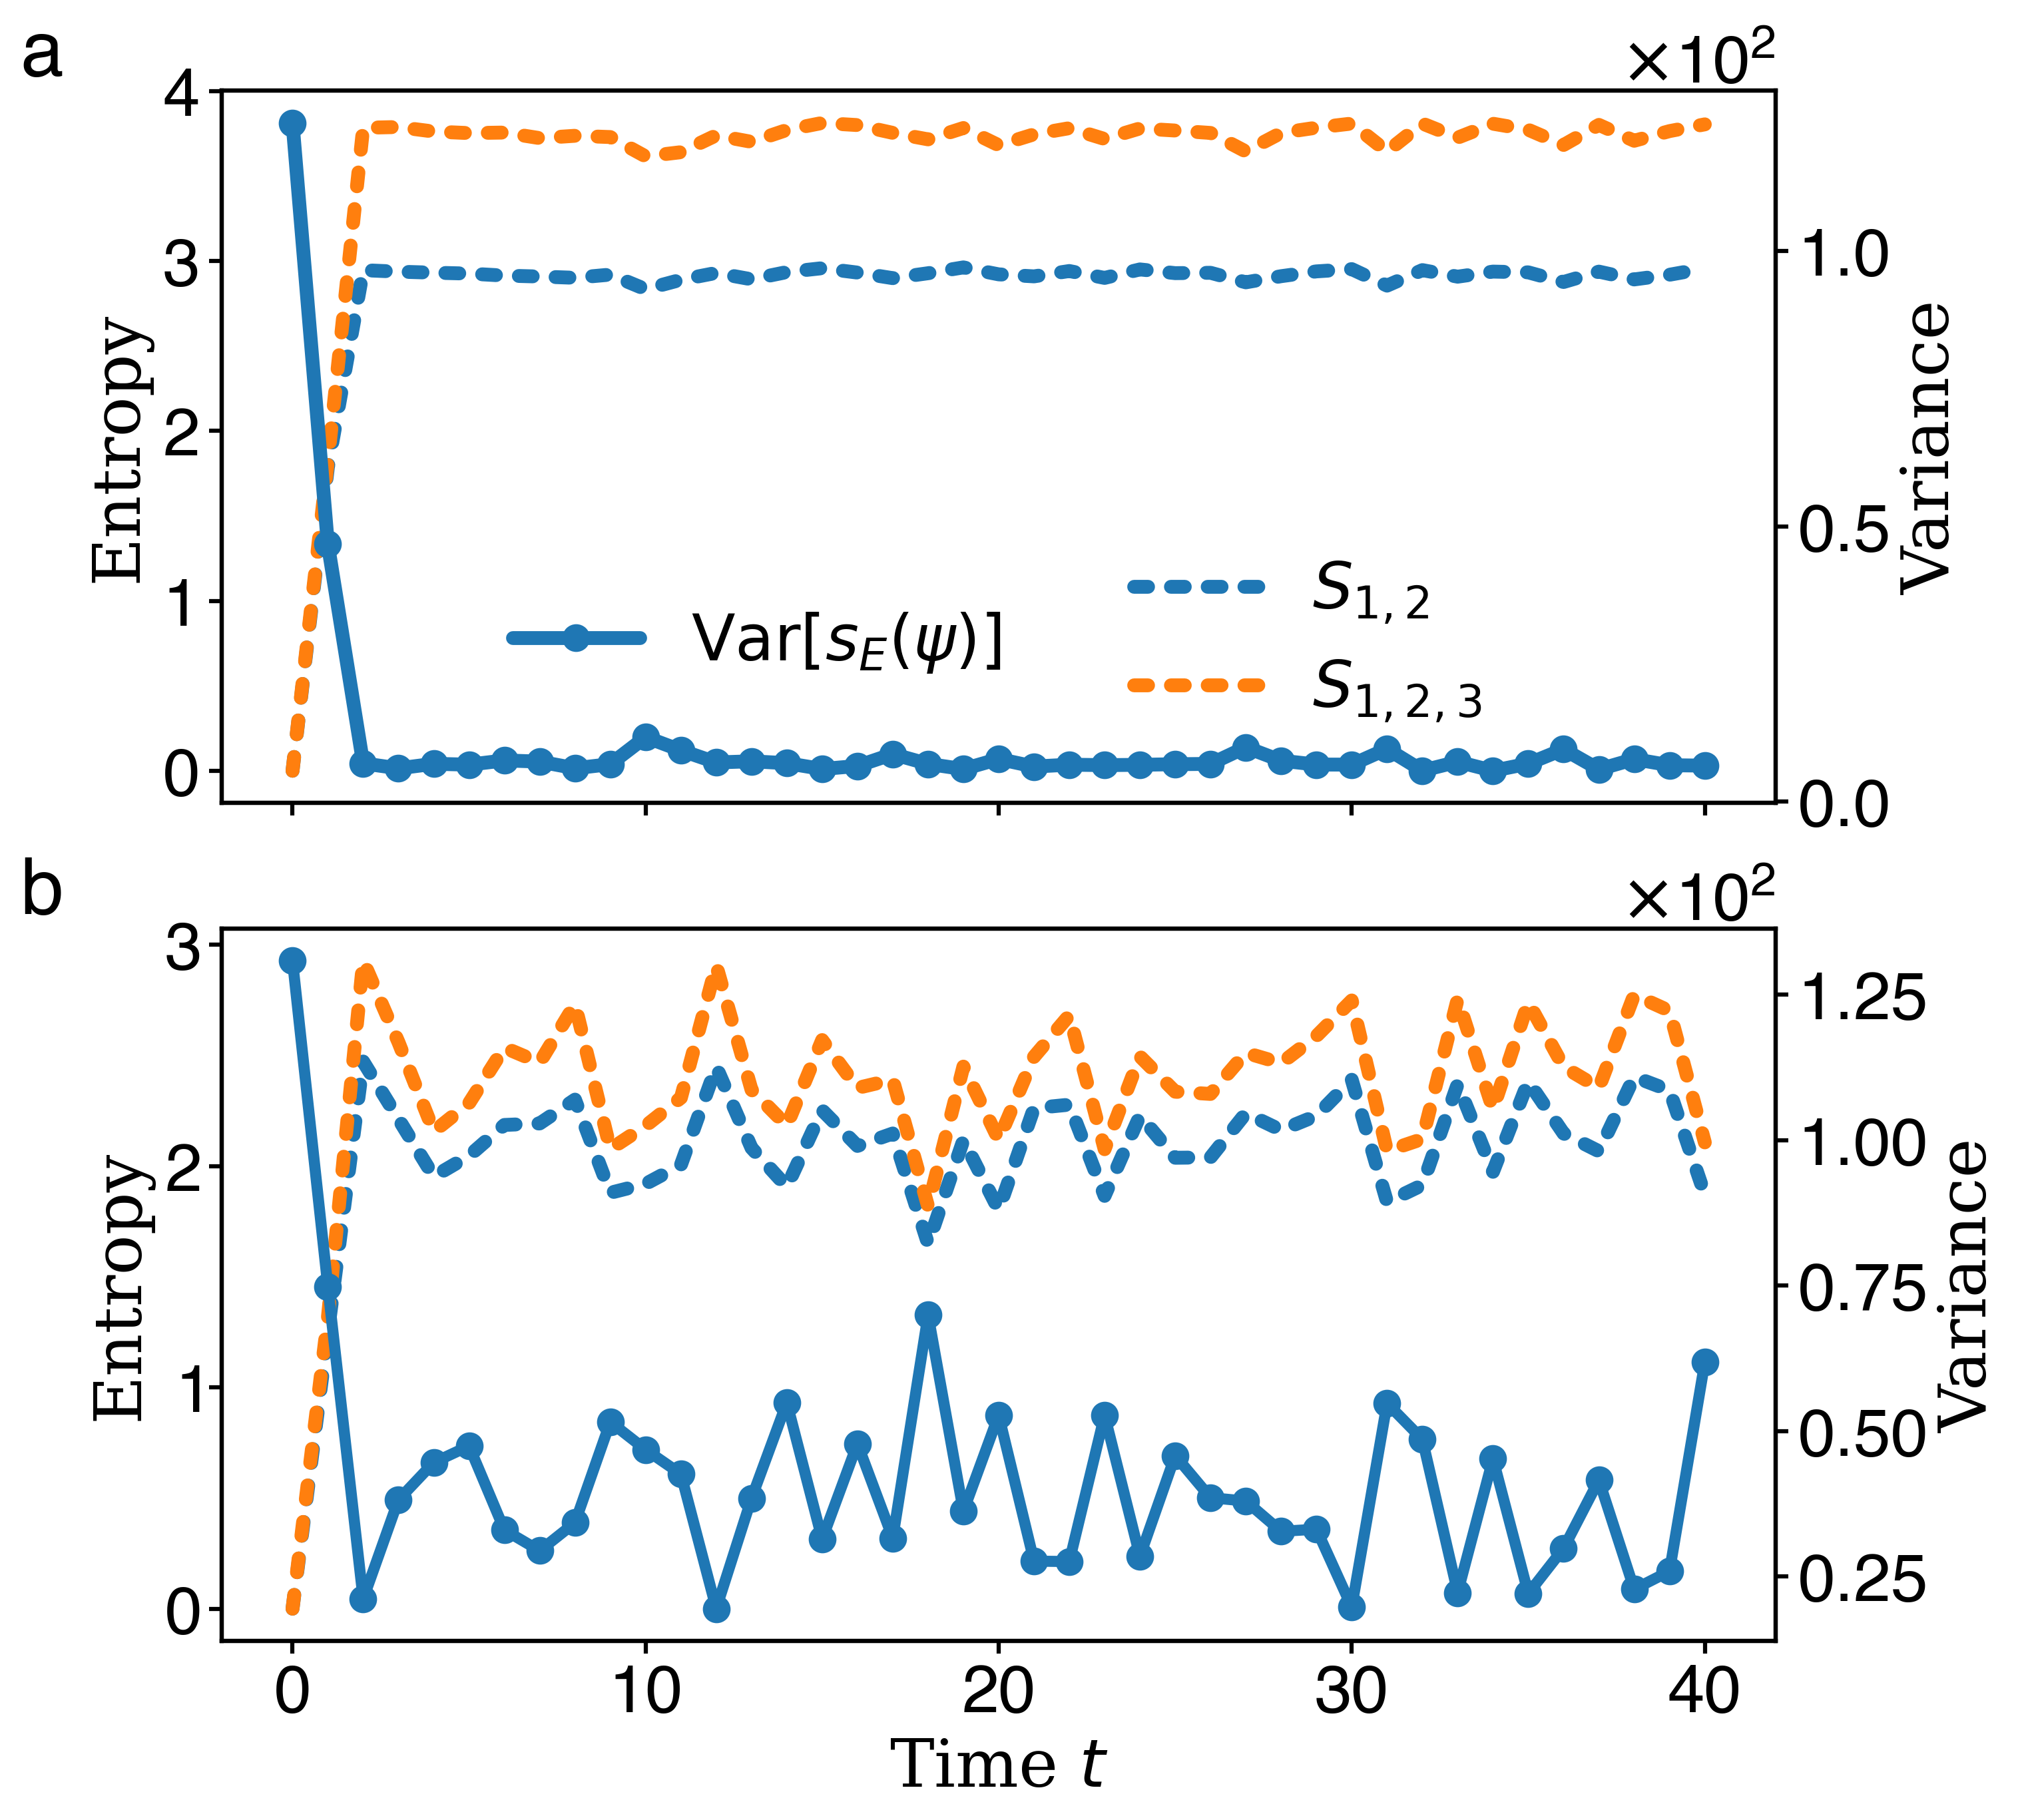

In [14]:
i = 0
moments_anti=[]
moments_ent=[]
while i < 41:
    moments_anti.append(np.var(np.power(AtypicalErrors[i],2)/np.power(delta_t,2*order+2)))
    moments_ent.append(np.var(np.power(TypicalErrors[i],2)/np.power(delta_t,2*order+2)))
    i+=1

# Create figure with two subplots side by side
fig, (ax1_right, ax1_left) = plt.subplots(2, 1, figsize=(10, 9), layout='constrained',sharex=True)
x=np.linspace(0,40,41)
ls=24
fontprops = {'family': 'serif', 'weight': 'normal', 'size': 24}
# ========== LEFT PLOT: ATYPICAL ==========
ax1_left.set_ylabel(r"Entropy", fontdict=fontprops)
ax1_left.set_xlabel(r"Time $t$", fontdict=fontprops)
ax1_left.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2),useMathText=True)
#part=[2,3,4]
part = [3, 4]
labels = [rf'$S_{{1,2}}$', rf'$S_{{1,2,3}}$', rf'$S_{{1,2,3,4}}$']
for j, m in enumerate(part):
    y = np.load(f"./vardata/part{m}atypical.npy")
    ax1_left.plot(x, y, label=labels[j], 
                  linestyle="dotted", linewidth=5)
ax1_left.tick_params(axis='y', which='major', labelsize=ls)

ax2_left = ax1_left.twinx()
ax2_left.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2),useMathText=True)
ax2_left.set_ylabel(r"Variance", fontdict=fontprops)

ax2_left.tick_params(axis='y', labelsize=ls, which='both')
ax2_left.tick_params(axis='x', labelsize=ls)
offset_text_left = ax2_left.yaxis.get_offset_text()
offset_text_left.set_fontsize(ls)
# ax1_left.set_title(r"(a) Atypical", fontdict=fontprops, pad=20)
ax2_left.plot(x, moments_anti, label=rf'$\text{{Var}}[s_E(\psi)]$',marker="o", 
              markersize=7, linestyle="-", markeredgewidth=3, linewidth=4)
#ax2_left.errorbar(x,moments_anti,yerr=np.array(AntiwithCI), fmt='o',linestyle='-',ecolor="#993A9C", elinewidth=2, capsize=3,linewidth=2,color=colors[0],markersize=4, markerfacecolor=colors[0],markeredgecolor=colors[0])




# ========== RIGHT PLOT: TYPICAL ==========
#ax1_right.set_xlabel(r"Time $t$", fontdict=fontprops)
# move the ylabel to the top of the axis
ax1_right.set_ylabel(r"Entropy", fontdict=fontprops)
# ax2_right.set_ylabel(r"Entropy", fontdict=fontprops, color=colors[8], rotation=0, ha='left', va='bottom')
# ax2_right.yaxis.set_label_coords(0.75, 1.02) 
# ax2_left.set_ylabel(r"Entropy", fontdict=fontprops, color=colors[8], rotation=0, ha='left', va='bottom')
# ax2_left.yaxis.set_label_coords(0.75, 1.02) 
for j, m in enumerate(part):
    y = np.load(f"./vardata/part{m}typical.npy")
    ax1_right.plot(x, y, label=labels[j], 
                   linestyle="dotted", linewidth=5)
ax1_right.tick_params(axis='y', which='major', labelsize=ls)

ax2_right = ax1_right.twinx()
ax2_right.set_ylabel(r"Variance", fontdict=fontprops)
ax2_right.plot(x, moments_ent,label=rf'$\text{{Var}}[s_E(\psi)]$',marker="o", markersize=7, linestyle="-", markeredgewidth=3, linewidth=5)
# ax2_right.errorbar(x,moments_ent,yerr=np.array(EntwithCI), fmt='o',linestyle='-',ecolor="#993A9C", elinewidth=2, 
#                   capsize=3,linewidth=2,color=colors[0],markersize=3.5, markerfacecolor=colors[0],markeredgecolor=colors[0],label=r"Variance")
ax2_right.ticklabel_format(style='sci', axis='y', scilimits=(-2, 2),useMathText=True)
ax2_right.tick_params(axis='y', labelsize=ls, which='both')
ax2_right.tick_params(axis='x', labelsize=ls)
offset_text_right = ax2_right.yaxis.get_offset_text()
offset_text_right.set_fontsize(ls)
# ax1_right.set_title(r"(b) Typical", fontdict=fontprops, pad=20)


# Optional: Add a shared legend
# lines1, labels1 = ax1_left.get_legend_handles_labels()
# lines2, labels2 = ax2_left.get_legend_handles_labels()
# fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
#            bbox_to_anchor=(0.3, 0.56), fontsize=22)
ax2_right.legend(loc='lower left', bbox_to_anchor=(0.15, 0.10), fontsize=23, framealpha=0)
ax1_right.legend(loc='lower left', bbox_to_anchor=(0.55, 0.03), fontsize=23, framealpha=0)
# fig.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
#            bbox_to_anchor=(0.5, 1.02), ncol=4, fontsize=24)

for ax, label in zip([ax1_right, ax1_left], ['a', 'b']): 
    ax.text(-0.13,1.1, label, transform=ax.transAxes, fontsize=28, va='top', weight='bold')